<a href="https://colab.research.google.com/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing modules required**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor, Dataset
from sklearn.metrics import mean_squared_error as mse
from downcast import reduce
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/new.pkl')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70,rolling_median_5,rolling_median_7,rolling_median_28,rolling_median_56
30490000,14370,1437,3,1,0,0,1001,2,11339,7,10,2013,-1,-1,-1,-1,0,0,0,8.257812,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
30490001,14380,1438,3,1,0,0,1001,0,11339,7,10,2013,-1,-1,-1,-1,0,0,0,3.970703,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# **Train, Test, Cross Validation for the model**

In [ ]:
# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

# Records till day 1914 will be used for training the model.
X_train = data[data['day']<1914]

# Records between days 1914 and 1941 will be used for Validation
X_val = data[(data['day']>=1914) & (data['day']<=1941)]

# Records after day 1942 will used for final test
X_test = data[(data['day']>=1942)]

y_train = X_train['demand']
y_val = X_val['demand']

# We are drpping the features which are not required.
X_train.drop(['demand'],axis = 1,inplace = True)
X_val.drop(['demand'],axis = 1,inplace = True)
X_test.drop(['demand'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(27837370, 27) (27837370,)
(853720, 27) (853720,)
(853720, 27)


# **LightGBM**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in range(15):
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)

    lgb = LGBMRegressor( learning_rate=lr ,
                            num_leaves=num_leaves ,
                            min_data_in_leaf=min_data_in_leaf)

    lgb.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = lgb.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.002, num_leaves 88 and min_data_in_leaf 101 the RMSE is 10.832683887724896 
********************************************************************************
For learning rate 0.098, num_leaves 75 and min_data_in_leaf 137 the RMSE is 4.968174905835645 
********************************************************************************
For learning rate 0.002, num_leaves 141 and min_data_in_leaf 112 the RMSE is 10.79968686064402 
********************************************************************************
For learning rate 0.046, num_leaves 48 and min_data_in_leaf 59 the RMSE is 5.087707910063227 
********************************************************************************
For learning rate 0.003, num_leaves 127 and min_data_in_leaf 121 the RMSE is 9.869213241625621 
********************************************************************************
For learning rate 0.048, num_leaves 83 and min_data_in_leaf 60 the RMSE is 5.048882772795383 
************************

In [ ]:
# After running several combinations, we found these parameter values to give best result

learning_rate = 0.074
num_leaves = 135
min_data_in_leaf = 85

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

lgb = LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {learning_rate}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")

For learning rate 0.074, num_leaves 135 and min_data_in_leaf 85 the RMSE is 4.950359727619904 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = lgb.predict(X_val)
pred_test_array  = lgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.799588,0.645370,0.641794,0.448406,1.064329,0.843335,0.852100,0.645981,1.169686,0.797205,1.376487,1.241466,1.313712,1.106001,0.409688,1.263560,0.647822,0.775764,0.977554,0.968038,1.000216,0.772389,0.834312,0.861474,1.271876,0.882477,1.437780,0.864342
1,HOBBIES_1_002_CA_1_validation,0.479410,0.309233,0.286147,0.467108,0.312115,0.466354,0.411817,0.341612,0.188894,0.190332,0.455880,0.289769,0.404054,0.388092,0.332718,0.187964,0.189278,0.357802,0.277328,0.389065,0.369874,0.281671,0.185981,0.308553,0.276324,0.335107,0.351893,0.317738
2,HOBBIES_1_003_CA_1_validation,0.385282,0.370340,0.247326,0.229080,0.477530,0.861790,0.553976,0.266724,0.470021,0.227718,0.339799,0.403145,0.926628,0.481725,0.279453,0.378297,0.337651,0.607883,0.649974,1.191439,1.090290,0.466353,0.763585,0.545274,0.585207,0.740711,0.593700,0.886735
3,HOBBIES_1_004_CA_1_validation,2.104940,0.924101,0.655443,1.374880,1.348142,1.694091,3.249665,1.513807,0.962241,0.789539,1.530276,1.638773,2.046877,2.932853,2.041138,1.220400,1.275514,0.941228,1.591666,1.749986,3.092693,1.991466,1.166458,1.428839,1.072431,1.645722,2.932608,2.664173
4,HOBBIES_1_005_CA_1_validation,1.102642,0.905447,1.092956,1.153426,1.376168,1.235788,1.393084,1.042960,1.242448,0.827937,1.155087,0.841499,0.964488,1.148300,1.142616,0.895113,1.118775,0.753149,1.172041,0.962394,1.347521,0.969909,0.806979,0.826401,1.096487,1.358503,1.227127,1.899966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.424802,0.364086,0.265664,0.607138,0.708331,0.595606,0.644126,0.371990,0.548850,0.293324,0.818991,0.860918,0.485506,0.734509,0.586671,0.568860,0.487472,0.581000,0.882994,0.499202,1.071348,0.421663,1.012529,0.569860,0.486409,0.765294,0.494413,0.825367
60976,FOODS_3_824_WI_3_evaluation,0.524135,0.422416,0.404122,0.529297,0.398298,0.583771,0.414125,0.411346,0.490179,0.379149,0.782174,0.400031,0.692022,0.491843,0.537621,0.468741,0.395849,0.630370,0.292981,0.526711,0.479228,0.467580,0.485285,0.426313,0.567511,0.290997,0.662989,0.327479
60977,FOODS_3_825_WI_3_evaluation,1.207754,0.516295,0.713288,0.386425,0.777298,0.956284,0.621568,1.189630,0.350201,0.811301,0.511487,0.671554,0.834038,0.812919,1.150259,0.828587,1.222356,1.020999,0.707706,0.939133,0.797814,1.204301,0.716252,1.515883,0.420809,0.627383,0.664861,0.927193
60978,FOODS_3_826_WI_3_evaluation,0.900915,1.621368,0.842450,1.235490,1.166573,0.977472,1.590655,1.188748,1.051457,1.124529,1.313323,1.272789,1.388324,1.519350,1.497345,1.132482,1.044251,1.225493,1.286686,1.081658,1.271115,1.361364,1.793947,1.387193,1.485323,1.028043,1.098043,1.116738


In [ ]:
sub.to_csv("lgb_sub_Final.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f lgb_sub_Final.csv -m "Test"

100% 32.7M/32.7M [00:01<00:00, 19.9MB/s]
Successfully submitted to M5 Forecasting - Accuracy

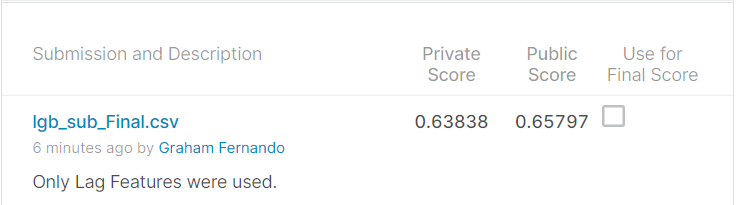

# **CATBOOST**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in range(8):
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)

    cbr = CatBoostRegressor(learning_rate=lr ,
                        # num_leaves=num_leaves ,
                        min_data_in_leaf=min_data_in_leaf,
                        logging_level="Silent", iterations=130)

    cbr.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = cbr.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.019, num_leaves 100 and min_data_in_leaf 102 the RMSE is 5.419876429147273 
********************************************************************************
For learning rate 0.008, num_leaves 122 and min_data_in_leaf 81 the RMSE is 6.850490625428555 
********************************************************************************
For learning rate 0.001, num_leaves 69 and min_data_in_leaf 83 the RMSE is 11.78894793346842 
********************************************************************************
For learning rate 0.049, num_leaves 148 and min_data_in_leaf 140 the RMSE is 5.097142515545817 
********************************************************************************
For learning rate 0.076, num_leaves 51 and min_data_in_leaf 74 the RMSE is 5.053819531311917 
********************************************************************************
For learning rate 0.083, num_leaves 72 and min_data_in_leaf 132 the RMSE is 5.05435332052517 
**************************

In [ ]:
# After running several combinations, we found these parameter values to give best result

learning_rate = 0.076
min_data_in_leaf = 74

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

cbr = CatBoostRegressor(learning_rate=learning_rate, min_data_in_leaf = min_data_in_leaf, iterations=100, logging_level="Silent")

cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {learning_rate}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")

For learning rate 0.076, num_leaves 77 and min_data_in_leaf 74 the RMSE is 5.0757273973153305 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = cbr.predict(X_val)
pred_test_array  = cbr.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.759291,0.675727,0.622414,0.417870,0.874934,0.759985,0.893501,0.672850,1.283154,0.806120,1.286596,1.038762,1.158641,1.014613,0.448364,1.220198,0.637966,0.773619,0.864877,1.030581,0.924418,0.768182,0.826945,0.779513,1.161436,0.900227,1.170368,0.900737
1,HOBBIES_1_002_CA_1_validation,0.474225,0.343653,0.317252,0.433971,0.306976,0.422524,0.403703,0.379159,0.260630,0.249689,0.410760,0.313532,0.404293,0.355077,0.341201,0.249689,0.251307,0.356313,0.295288,0.378430,0.377331,0.316578,0.239241,0.345277,0.314031,0.365643,0.357849,0.331448
2,HOBBIES_1_003_CA_1_validation,0.383375,0.388243,0.278414,0.252014,0.399051,0.899087,0.540365,0.321687,0.498540,0.262462,0.364987,0.379654,1.004840,0.444534,0.301072,0.382555,0.370116,0.586191,0.688742,1.219863,0.893798,0.462463,0.672517,0.503797,0.556581,0.685776,0.550524,0.751260
3,HOBBIES_1_004_CA_1_validation,2.019737,1.097675,0.630498,1.382622,1.263499,1.737507,3.068237,1.318417,1.092962,0.772047,1.451939,1.444433,1.880252,2.984367,1.931839,1.072875,1.274722,0.942771,1.424384,1.642020,2.876963,1.856963,1.271084,1.264248,1.137928,1.431611,2.719613,2.624107
4,HOBBIES_1_005_CA_1_validation,0.982999,0.897309,1.175194,1.069939,1.187452,1.120617,1.409780,0.900511,1.318492,0.908506,1.166500,0.747734,0.842147,1.084173,1.091981,0.812233,1.067622,0.763412,1.024155,0.820688,1.217417,0.903749,0.760385,0.807709,0.981992,1.224430,1.109122,1.698049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.417199,0.333757,0.257576,0.573204,0.669065,0.521685,0.591577,0.373260,0.509443,0.270324,0.790922,0.768215,0.413354,0.632738,0.585116,0.508697,0.445915,0.564686,0.801735,0.465584,1.075794,0.379978,0.977135,0.524553,0.508310,0.699555,0.457451,0.797685
60976,FOODS_3_824_WI_3_evaluation,0.517335,0.416514,0.363613,0.439794,0.333757,0.553866,0.400817,0.404600,0.475169,0.334085,0.743953,0.343822,0.673027,0.467802,0.509833,0.414133,0.392780,0.584404,0.266381,0.486936,0.431390,0.372096,0.461177,0.384550,0.571031,0.257576,0.555553,0.303766
60977,FOODS_3_825_WI_3_evaluation,1.092730,0.521970,0.707187,0.371928,0.681973,0.926328,0.607158,1.209693,0.364860,0.774120,0.503285,0.585491,0.824791,0.785940,1.038041,0.825419,1.164825,0.951851,0.704900,0.872670,0.756237,1.025868,0.742021,1.378011,0.406849,0.545479,0.584029,0.865797
60978,FOODS_3_826_WI_3_evaluation,0.967560,1.739747,0.816846,1.248598,1.174368,1.030583,1.606878,1.196578,1.076234,1.063174,1.338685,1.176222,1.357261,1.602367,1.494758,1.035264,1.124773,1.196554,1.270114,1.149505,1.367152,1.504750,2.018346,1.311341,1.818754,1.026159,1.094511,1.043804


In [ ]:
sub.to_csv("cbr_sub_V2.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f cbr_sub_V2.csv -m "First CatBoost Model"

100% 32.7M/32.7M [00:01<00:00, 22.5MB/s]
Successfully submitted to M5 Forecasting - Accuracy

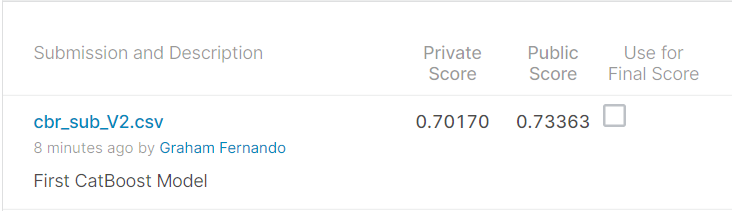

# **XGBoost**

In [ ]:
for i in range(10):
    lr = np.round(np.random.rand()/10,3)
    min_child_weight  = np.random.randint(30,150)
    max_leaves = np.random.randint(30,100)

    xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 ) 
    
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_val)
    rmse = mse(y_val,y_pred)

    print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.071, min_child_weight 97 and max_leaves 74 the RMSE is 5.130997235548195 
********************************************************************************
For learning rate 0.074, min_child_weight 119 and max_leaves 86 the RMSE is 5.114757907043766 
********************************************************************************
For learning rate 0.05, min_child_weight 115 and max_leaves 60 the RMSE is 5.170266210649444 
********************************************************************************
For learning rate 0.044, min_child_weight 59 and max_leaves 68 the RMSE is 5.20024316505762 
********************************************************************************
For learning rate 0.017, min_child_weight 139 and max_leaves 98 the RMSE is 5.965988773280025 
********************************************************************************
For learning rate 0.06, min_child_weight 55 and max_leaves 79 the RMSE is 5.144295820247376 
*******************************

In [ ]:
lr = 0.074
min_child_weight  = 119
max_leaves = 86

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {rmse} ")

For learning rate 0.074, min_child_weight 119 and max_leaves 86 the RMSE is 5.114757907043766 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = xgb.predict(X_val)
pred_test_array  = xgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.835742,0.718145,0.607976,0.355319,0.894233,0.856304,0.890733,0.731268,1.386984,0.717000,1.338368,1.063138,1.197387,1.079604,0.387778,1.256892,0.631730,0.759092,0.863617,0.962658,0.892708,0.763987,0.932513,0.748429,1.182228,0.857212,1.245363,0.832943
1,HOBBIES_1_002_CA_1_validation,0.441333,0.331783,0.311499,0.371564,0.304031,0.379704,0.358983,0.333902,0.239943,0.234309,0.378041,0.287863,0.339129,0.329618,0.312806,0.234309,0.241892,0.330559,0.260931,0.308321,0.330697,0.281215,0.236257,0.341417,0.282726,0.337684,0.313442,0.293158
2,HOBBIES_1_003_CA_1_validation,0.342639,0.374224,0.263008,0.242724,0.378700,1.023184,0.505449,0.272595,0.480061,0.240775,0.358462,0.325895,1.068514,0.385301,0.273392,0.361753,0.360410,0.606821,0.643970,1.314468,0.971687,0.443409,0.721855,0.490898,0.573095,0.668340,0.532103,0.754865
3,HOBBIES_1_004_CA_1_validation,2.048544,1.199387,0.622713,1.464883,1.391016,1.848323,3.261893,1.432481,1.065727,0.749135,1.512859,1.530638,2.086873,3.114543,2.018768,1.159155,1.286072,0.993960,1.574472,1.783782,2.962968,1.841518,1.415629,1.363736,1.175682,1.463305,2.582619,2.777621
4,HOBBIES_1_005_CA_1_validation,0.978402,0.911024,1.258985,1.133430,1.316534,1.243119,1.480329,0.827557,1.361461,0.842301,1.136792,0.751990,0.784973,1.092074,1.096029,0.781715,1.193064,0.899196,1.053998,0.809275,1.348276,0.944672,0.725195,0.871579,1.115088,1.232938,1.139363,1.863808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.411936,0.334384,0.268641,0.612029,0.695733,0.559127,0.618719,0.393145,0.552438,0.278259,0.772104,0.723270,0.441830,0.587337,0.511838,0.543031,0.388171,0.455552,0.792000,0.389230,0.990007,0.409454,0.895627,0.461278,0.485073,0.687376,0.491698,0.831563
60976,FOODS_3_824_WI_3_evaluation,0.506807,0.421720,0.373801,0.439544,0.334384,0.486180,0.351251,0.437836,0.451071,0.337851,0.692143,0.294578,0.643103,0.373965,0.450009,0.411955,0.330930,0.541526,0.266693,0.398281,0.380603,0.417566,0.362377,0.314204,0.534774,0.268641,0.557409,0.319497
60977,FOODS_3_825_WI_3_evaluation,1.246269,0.479622,0.829673,0.379443,0.702812,0.925911,0.596644,1.345465,0.354102,0.833346,0.441296,0.530256,0.799096,0.709618,1.025482,0.832118,1.169983,0.856102,0.791538,0.735720,0.717125,1.211386,0.677291,1.272739,0.387363,0.558909,0.566021,0.914211
60978,FOODS_3_826_WI_3_evaluation,0.964555,1.722158,0.812057,1.330379,1.144919,0.942219,1.673292,1.184949,1.096096,1.087131,1.237263,1.169922,1.305601,1.448973,1.339930,1.073835,0.970817,1.112249,1.296108,1.020384,1.255445,1.601080,2.083296,1.416716,1.899925,1.031471,0.982772,1.077861


In [ ]:
sub.to_csv("xgb_sub_V1.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f xgb_sub_V1.csv -m "First XGBoost Model"

100% 18.5M/18.5M [00:03<00:00, 5.59MB/s]
Successfully submitted to M5 Forecasting - Accuracy

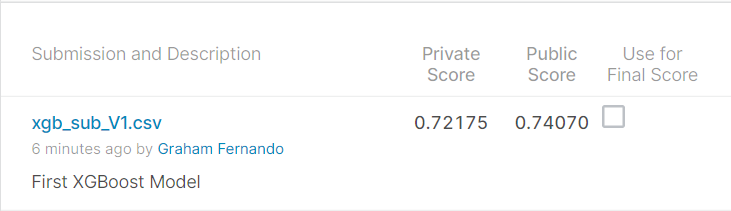

# **LinearRegression**

In [ ]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
rmse = mse(y_val,y_pred)
print(f"The RMSE score is {rmse}")

The RMSE score is 3.4552652266766395


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = model.predict(X_val)
pred_test_array  = model.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.093722,0.422479,0.177559,0.105548,0.315239,0.263125,1.663847,1.603813,0.559825,1.209743,1.095021,0.501405,1.251717,1.416658,1.054853,1.878584,1.770898,1.156904,1.951576,2.179592,1.498123,0.365983,0.366088,0.253625,0.386497,0.133781,0.396458,1.040169
1,HOBBIES_1_002_CA_1_validation,0.301362,0.174783,0.110531,0.243564,0.106091,0.291527,0.279298,0.343941,0.248708,0.163111,0.270527,0.183836,0.407524,0.324763,0.345996,0.196231,0.183865,0.242229,0.132106,0.365983,0.362078,0.915791,1.010699,1.048768,1.002545,0.280214,0.336160,0.271908
2,HOBBIES_1_003_CA_1_validation,1.079378,1.107064,1.102085,1.130281,0.575027,1.513041,1.414727,1.332170,0.698527,0.356705,0.410216,0.422309,0.709283,1.198847,1.135888,1.071447,1.294839,0.742312,0.694508,0.765816,1.324793,0.480457,0.361569,0.244061,0.318245,0.369935,0.467601,1.110299
3,HOBBIES_1_004_CA_1_validation,1.965178,1.543123,1.076025,1.633220,1.547881,1.672658,2.597576,3.827989,3.490873,1.453479,0.703272,0.727116,1.259780,2.652075,2.120214,1.719377,1.880838,1.304387,1.209738,1.712623,2.146103,1.666533,1.076753,1.109471,1.127953,1.371966,2.051647,2.703928
4,HOBBIES_1_005_CA_1_validation,2.235556,2.121866,2.202058,2.047958,1.222855,1.107817,2.119152,2.152621,2.094401,2.097529,1.868582,2.005218,2.202728,2.370495,2.372929,2.253962,2.302140,2.222628,2.166348,2.347270,1.139584,0.998010,0.718772,0.611805,0.589194,1.167070,1.526706,1.041682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.474188,0.129396,0.112203,0.273016,0.274364,0.215670,0.228424,0.203984,0.293383,0.170936,0.101786,0.384947,0.361049,0.398967,0.316918,0.182499,0.241919,0.287751,0.332205,0.356488,0.568727,0.253446,0.278717,0.286673,0.184797,0.247397,0.372338,0.464731
60976,FOODS_3_824_WI_3_evaluation,0.302505,0.269584,0.190611,0.135881,0.025890,0.367888,0.301980,0.234437,0.317326,0.224029,0.181265,0.128107,0.353505,0.361705,0.346899,0.235420,0.215280,0.301669,0.075630,0.406477,0.325637,0.293251,0.288394,0.213185,0.287642,0.046748,0.378704,0.198737
60977,FOODS_3_825_WI_3_evaluation,0.635679,0.311215,0.383605,0.026964,0.054830,0.590947,0.429153,0.556437,0.153519,0.377289,0.113113,0.261556,0.537168,0.535326,0.607203,0.319801,0.553980,0.257787,0.077387,0.517474,0.499658,0.605852,0.322124,0.531574,0.206424,0.131429,0.449756,0.480034
60978,FOODS_3_826_WI_3_evaluation,1.168807,0.445196,0.171236,0.230932,0.342416,0.386270,0.520620,0.333072,0.394936,0.163655,0.103999,0.123900,0.310035,0.482619,0.276403,0.212400,0.283724,0.513786,0.364440,0.584390,0.631385,0.711274,0.870645,0.307943,0.326005,0.404473,0.568822,0.438074


In [ ]:
sub.to_csv("linear_reg_without_norm.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f linear_reg_without_norm.csv -m "Linear Reg model, norm is False, with rolling features"

100% 33.2M/33.2M [00:01<00:00, 26.4MB/s]
Successfully submitted to M5 Forecasting - Accuracy

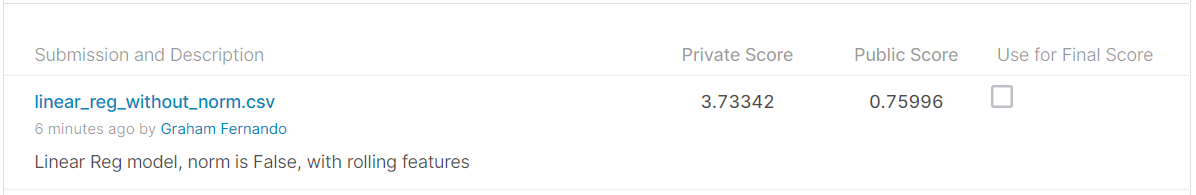

# **LinearRegression without Rolling Window Features**

In [ ]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
rmse = mse(y_val,y_pred)
print(f"The RMSE score is {rmse}")

The RMSE score is 5.155335710142915


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = model.predict(X_val)
pred_test_array  = model.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.921387,0.745117,0.723145,0.461426,0.977295,0.836914,1.005127,0.865723,1.553223,0.998535,1.501953,1.239746,1.380127,1.321533,0.553467,1.329590,0.794434,1.013184,1.048828,1.199707,1.133545,0.889404,0.946289,0.980225,1.355957,0.995361,1.330322,0.954346
1,HOBBIES_1_002_CA_1_validation,0.613281,0.433105,0.314941,0.545898,0.274170,0.455078,0.462891,0.532227,0.344482,0.262695,0.647461,0.379395,0.507324,0.466064,0.510254,0.256592,0.303711,0.556152,0.314697,0.486816,0.513428,0.431641,0.232422,0.399170,0.386719,0.388916,0.447510,0.329590
2,HOBBIES_1_003_CA_1_validation,0.445801,0.389893,0.312256,0.194336,0.477051,0.889404,0.732178,0.435303,0.653809,0.278809,0.487061,0.476562,1.164307,0.596436,0.441162,0.446289,0.503418,0.783203,0.905273,1.535156,1.228027,0.670410,0.875244,0.648438,0.646240,0.901611,0.760254,0.971191
3,HOBBIES_1_004_CA_1_validation,2.062988,1.202148,0.695312,1.451904,1.303467,1.856445,3.265381,1.672852,1.398193,0.994141,1.596436,1.738281,2.203857,3.292480,2.252441,1.233154,1.526855,1.042480,1.595459,1.806641,3.235352,2.195557,1.449707,1.456055,1.185303,1.596436,2.956787,2.837646
4,HOBBIES_1_005_CA_1_validation,1.278320,1.110840,1.534424,1.190918,1.245361,1.266357,1.658447,1.176025,1.623291,1.072754,1.364990,0.916016,1.207031,1.297607,1.538574,1.126953,1.442383,0.942383,1.259033,1.199951,1.486816,1.243652,1.087158,1.129395,1.226318,1.477783,1.439209,2.033203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.444824,0.377686,0.240723,0.704346,0.745361,0.524902,0.621338,0.360596,0.602051,0.337402,0.781982,0.912109,0.536621,0.789551,0.677246,0.595703,0.505615,0.585449,1.012695,0.506592,1.241943,0.497559,1.029053,0.623047,0.613525,0.882324,0.574707,0.941406
60976,FOODS_3_824_WI_3_evaluation,0.649902,0.534668,0.432617,0.535645,0.335449,0.693604,0.443848,0.460449,0.620605,0.458740,0.838867,0.348145,0.859863,0.582520,0.652344,0.542725,0.415283,0.653320,0.260254,0.670898,0.572998,0.621826,0.575928,0.415771,0.688232,0.236084,0.805420,0.355957
60977,FOODS_3_825_WI_3_evaluation,1.368408,0.626709,0.947021,0.492676,0.858398,1.203125,0.771484,1.563965,0.425293,0.986328,0.511230,0.688965,1.109375,1.042725,1.264404,0.991455,1.370361,1.059814,0.769287,1.110840,1.017578,1.483643,0.858887,1.646973,0.508057,0.689209,0.828369,1.200439
60978,FOODS_3_826_WI_3_evaluation,1.033447,1.748047,0.857178,1.320557,1.210449,1.084961,1.657227,1.274658,1.039062,1.163574,1.289795,1.157715,1.475586,1.614502,1.538086,1.026367,1.117676,1.202881,1.204346,1.204102,1.425781,1.672119,2.182373,1.333740,1.902832,1.075439,1.189697,1.142334


In [ ]:
sub.to_csv("linear_reg_without_rolling.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f linear_reg_without_rolling.csv -m "Linear Reg model,without rolling features"

100% 18.5M/18.5M [00:01<00:00, 10.6MB/s]
Successfully submitted to M5 Forecasting - Accuracy

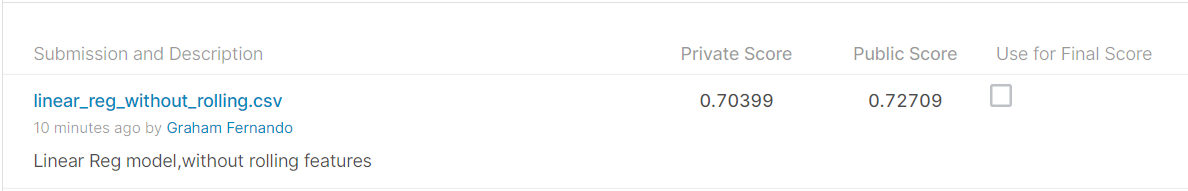

# **ElasticNet**

In [ ]:
alp = [0.01,0.1,1,10]
l1_ratio = [0.01,0.1,1]

for i in alp:
    for j in l1_ratio:
        model = ElasticNet(alpha=i,l1_ratio=j, max_iter=250)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        rmse = mse(y_val,y_pred)
        print(f"For alpha {i} and l1_ratio {j} the RMSE is {rmse} ")
        print('*'*80)

For alpha 0.01 and l1_ratio 0.01 the RMSE is 5.155661656035502 
********************************************************************************
For alpha 0.01 and l1_ratio 0.1 the RMSE is 5.15576413040694 
********************************************************************************
For alpha 0.01 and l1_ratio 1 the RMSE is 5.157393379233565 
********************************************************************************
For alpha 0.1 and l1_ratio 0.01 the RMSE is 5.156879754507387 
********************************************************************************
For alpha 0.1 and l1_ratio 0.1 the RMSE is 5.158724404273319 
********************************************************************************
For alpha 0.1 and l1_ratio 1 the RMSE is 5.1707991599495635 
********************************************************************************
For alpha 1 and l1_ratio 0.01 the RMSE is 5.1722755069966855 
*******************************************************************************

In [ ]:
alpha = 0.01
l1_ratio = 0.01

In [ ]:
model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio, max_iter=250)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
rmse = mse(y_val,y_pred)
print(f"For alpha {i} and l1_ratio {j} the RMSE is {rmse} ")

For alpha 10 and l1_ratio 1 the RMSE is 5.155661656035502 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = model.predict(X_val)
pred_test_array  = model.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.934385,0.759724,0.740898,0.481377,1.000074,0.873161,0.996481,0.848803,1.553789,0.978018,1.509932,1.246885,1.381866,1.325970,0.571827,1.327862,0.782558,1.005634,1.033754,1.185274,1.134451,0.870003,0.930410,0.967356,1.346836,0.989239,1.328217,0.955379
1,HOBBIES_1_002_CA_1_validation,0.624992,0.447826,0.332735,0.566931,0.298697,0.490580,0.454386,0.516468,0.344637,0.242859,0.656416,0.388493,0.510643,0.471418,0.529949,0.255850,0.292261,0.547750,0.299292,0.472782,0.514950,0.413170,0.217255,0.387348,0.377508,0.382212,0.445614,0.330523
2,HOBBIES_1_003_CA_1_validation,0.457367,0.404617,0.330503,0.215410,0.501450,0.924517,0.723333,0.419403,0.653685,0.259109,0.496410,0.485569,1.169460,0.602291,0.461008,0.446358,0.492388,0.775801,0.889589,1.520378,1.230036,0.652266,0.859596,0.636709,0.637562,0.896097,0.759054,0.972710
3,HOBBIES_1_004_CA_1_validation,2.074015,1.215939,0.714386,1.473875,1.328342,1.892345,3.258144,1.654869,1.398039,0.973421,1.603037,1.747210,2.207251,3.298500,2.271032,1.232107,1.514948,1.032597,1.579113,1.792160,3.237078,2.178860,1.432673,1.443598,1.176430,1.591406,2.955256,2.838085
4,HOBBIES_1_005_CA_1_validation,1.289919,1.126062,1.553137,1.213806,1.267496,1.300779,1.650105,1.159681,1.622606,1.053520,1.374912,0.924341,1.210283,1.303452,1.558344,1.125448,1.430017,0.934196,1.244656,1.186203,1.488245,1.225924,1.071814,1.116661,1.216803,1.473175,1.437799,2.034245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.445835,0.381468,0.247894,0.715181,0.758471,0.541813,0.641350,0.387970,0.628637,0.319576,0.773998,0.910410,0.516016,0.795225,0.685379,0.604603,0.507139,0.602455,1.009836,0.494860,1.233328,0.482008,1.012089,0.623621,0.592594,0.865080,0.561825,0.862810
60976,FOODS_3_824_WI_3_evaluation,0.650227,0.538879,0.439907,0.545923,0.348269,0.710793,0.463903,0.488281,0.647038,0.441031,0.831585,0.346394,0.838690,0.588131,0.661480,0.551323,0.416592,0.671206,0.257605,0.658951,0.564346,0.605644,0.559727,0.415390,0.667870,0.219007,0.792377,0.276747
60977,FOODS_3_825_WI_3_evaluation,1.368874,0.630260,0.953518,0.503126,0.871223,1.220247,0.791420,1.590048,0.451004,0.967701,0.503601,0.686356,1.088537,1.048820,1.272942,1.000553,1.373243,1.076838,0.765675,1.098442,1.009542,1.468658,0.843323,1.646242,0.487804,0.672623,0.814486,1.120625
60978,FOODS_3_826_WI_3_evaluation,1.034235,1.751125,0.865057,1.329876,1.224958,1.103262,1.678802,1.304041,1.066191,1.145021,1.281393,1.155727,1.454777,1.619682,1.546600,1.035280,1.119738,1.221233,1.200581,1.192652,1.416956,1.656542,2.166574,1.332905,1.882179,1.058182,1.176424,1.062513


In [ ]:
sub.to_csv("Elastic_Net_without_rolling.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f Elastic_Net_without_rolling.csv -m "Elastic Net model,without rolling features"

100% 18.5M/18.5M [00:01<00:00, 9.82MB/s]
Successfully submitted to M5 Forecasting - Accuracy

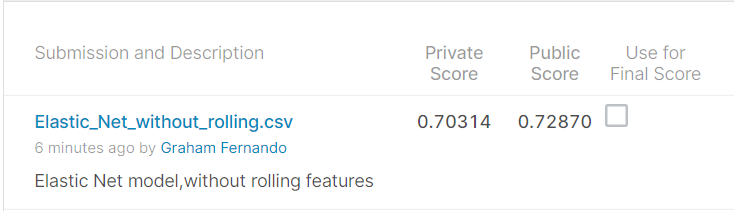

# **Ridge Regression**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

alpha = [0.001,0.01,0.1,1,10,0.05,0.5]

for i in alpha:
    
    model = Ridge(alpha=i)

    model.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = model.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For alpha value {i} the RMSE is {rmse} ")
    print('*'*80)

For alpha value 0.001 the RMSE is 5.155416864365827 
********************************************************************************
For alpha value 0.01 the RMSE is 5.155410695795249 
********************************************************************************
For alpha value 0.1 the RMSE is 5.155418475822207 
********************************************************************************
For alpha value 1 the RMSE is 5.155407097247136 
********************************************************************************
For alpha value 10 the RMSE is 5.155407085268537 
********************************************************************************
For alpha value 0.05 the RMSE is 5.155413511245975 
********************************************************************************
For alpha value 0.5 the RMSE is 5.155416569311943 
********************************************************************************


In [ ]:
# We are re-training our model with the best alpha value.
model = Ridge(alpha=1)

model.fit(X_train, y_train)

# After training the model, we are trying to predict the model on X_val to check it's accuracy
y_pred = model.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For alpha value 1, the RMSE score is {rmse}")

For alpha value 1, the RMSE score is 5.155407097247136


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = model.predict(X_val)
pred_test_array  = model.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.923096,0.745117,0.722656,0.460205,0.975342,0.838623,1.006104,0.864990,1.554443,0.998779,1.501465,1.237305,1.379639,1.322021,0.553223,1.328857,0.794189,1.013916,1.048828,1.201660,1.133789,0.889160,0.945801,0.979736,1.356201,0.994873,1.331543,0.955322
1,HOBBIES_1_002_CA_1_validation,0.613770,0.432861,0.314209,0.545166,0.273682,0.456299,0.463623,0.532715,0.344482,0.262695,0.646973,0.378418,0.508301,0.466553,0.510498,0.256592,0.303467,0.555420,0.313721,0.487793,0.513672,0.431641,0.232422,0.399658,0.386475,0.387695,0.448730,0.330322
2,HOBBIES_1_003_CA_1_validation,0.445801,0.389648,0.312256,0.193604,0.476318,0.890625,0.732666,0.435547,0.653320,0.278809,0.487305,0.475586,1.166260,0.597412,0.441650,0.446777,0.503906,0.783936,0.904541,1.535156,1.228760,0.670654,0.874756,0.648682,0.645996,0.901367,0.762207,0.972412
3,HOBBIES_1_004_CA_1_validation,2.062012,1.200684,0.695801,1.451904,1.303223,1.858154,3.267334,1.671387,1.398438,0.993164,1.593262,1.737793,2.205566,3.293457,2.252197,1.232422,1.527100,1.041016,1.593506,1.807617,3.236816,2.197754,1.447754,1.455322,1.185303,1.597168,2.959717,2.838135
4,HOBBIES_1_005_CA_1_validation,1.278564,1.111084,1.535645,1.192627,1.241943,1.266113,1.659912,1.175781,1.622070,1.072998,1.365479,0.914551,1.207764,1.299072,1.539307,1.125977,1.440918,0.941895,1.259277,1.201172,1.486572,1.244385,1.086914,1.128906,1.225830,1.478271,1.440674,2.034424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.444336,0.376953,0.240234,0.704590,0.744385,0.524902,0.621094,0.360107,0.602295,0.336914,0.780518,0.911133,0.537598,0.790283,0.676758,0.595703,0.505371,0.583984,1.011230,0.507568,1.243408,0.498047,1.027832,0.623291,0.611816,0.880615,0.575684,0.942871
60976,FOODS_3_824_WI_3_evaluation,0.648926,0.534424,0.432373,0.535156,0.333984,0.694092,0.443848,0.460205,0.620605,0.458252,0.838867,0.346680,0.859863,0.583008,0.652832,0.542480,0.414307,0.652588,0.258789,0.671387,0.573486,0.621582,0.575439,0.414795,0.687256,0.234619,0.806396,0.356445
60977,FOODS_3_825_WI_3_evaluation,1.367676,0.625732,0.946289,0.492432,0.856689,1.204102,0.771729,1.562256,0.424561,0.985107,0.510986,0.686768,1.109863,1.043945,1.264893,0.992188,1.371338,1.058350,0.766846,1.111084,1.019043,1.484863,0.859131,1.645752,0.507080,0.688477,0.828369,1.200928
60978,FOODS_3_826_WI_3_evaluation,1.033203,1.747070,0.856934,1.318359,1.210693,1.086426,1.658447,1.275879,1.039551,1.162109,1.288818,1.156006,1.476318,1.613770,1.537842,1.026123,1.117676,1.202637,1.201660,1.205322,1.426025,1.673096,2.183350,1.332031,1.900635,1.074463,1.190186,1.141846


In [ ]:
sub.to_csv("Ridge_reg.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f Ridge_reg.csv -m "Ridge Regression"

100% 18.5M/18.5M [00:00<00:00, 41.5MB/s]
Successfully submitted to M5 Forecasting - Accuracy

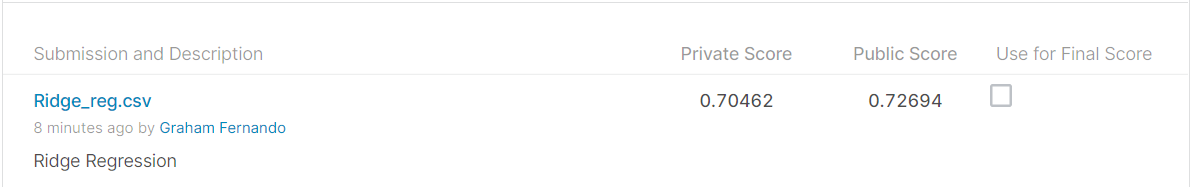

# **Lasso Regression**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

alpha = [0.001,0.01,0.1,1,10,0.05,0.5]

for i in alpha:
    
    model = Lasso(alpha=i)

    model.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = model.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For alpha value {i} the RMSE is {rmse} ")
    print('*'*80)

For alpha value 0.001 the RMSE is 5.155680618201587 
********************************************************************************
For alpha value 0.01 the RMSE is 5.1573933304666495 
********************************************************************************
For alpha value 0.1 the RMSE is 5.1707991599495635 
********************************************************************************
For alpha value 1 the RMSE is 5.381181507842819 
********************************************************************************
For alpha value 10 the RMSE is 13.094783808953778 
********************************************************************************
For alpha value 0.05 the RMSE is 5.164287034573407 
********************************************************************************
For alpha value 0.5 the RMSE is 5.243447646492869 
********************************************************************************


In [ ]:
# We are re-training our model with the best alpha value.
model = Lasso(alpha=0.001)

model.fit(X_train, y_train)

# After training the model, we are trying to predict the model on X_val to check it's accuracy
y_pred = model.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For alpha value 0.001, the RMSE score is {rmse}")

For alpha value 0.001, the RMSE score is 5.155680618201587


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = model.predict(X_val)
pred_test_array  = model.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.930976,0.756351,0.737743,0.478434,0.997177,0.871836,0.992510,0.842893,1.547379,0.973222,1.506522,1.240454,1.374854,1.317691,0.564687,1.322735,0.777401,1.001000,1.029646,1.181147,1.128678,0.866431,0.926865,0.964173,1.344231,0.986491,1.324305,0.951534
1,HOBBIES_1_002_CA_1_validation,0.621215,0.444168,0.329316,0.563689,0.295771,0.488948,0.450073,0.510238,0.337353,0.237531,0.652104,0.381886,0.503100,0.462561,0.522489,0.250409,0.286848,0.542527,0.294732,0.467768,0.508892,0.409070,0.213439,0.383953,0.374170,0.379121,0.441190,0.326338
2,HOBBIES_1_003_CA_1_validation,0.453329,0.400770,0.326993,0.212141,0.498388,0.922702,0.719053,0.413074,0.646288,0.253694,0.492257,0.478827,1.161780,0.593397,0.453513,0.440810,0.487060,0.770901,0.885281,1.515483,1.224236,0.648305,0.855889,0.633245,0.634127,0.893106,0.754728,0.968617
3,HOBBIES_1_004_CA_1_validation,2.069907,1.212300,0.710962,1.470593,1.325707,1.890868,3.254039,1.648463,1.391254,0.968101,1.598440,1.740904,2.200247,3.290038,2.263807,1.226709,1.509958,1.027188,1.574626,1.786931,3.231616,2.175418,1.428926,1.440018,1.173211,1.588606,2.951673,2.833976
4,HOBBIES_1_005_CA_1_validation,1.285880,1.122192,1.550200,1.211173,1.264164,1.299085,1.646221,1.153119,1.615170,1.048002,1.370797,0.917497,1.202777,1.294662,1.550993,1.119755,1.424394,0.928881,1.240307,1.181232,1.482059,1.221693,1.067961,1.112958,1.213491,1.470336,1.433531,2.030430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.443894,0.379887,0.246550,0.714438,0.757852,0.539639,0.639430,0.387826,0.627524,0.315029,0.778492,0.906043,0.512099,0.789791,0.680038,0.601482,0.503782,0.597714,1.007262,0.490694,1.229887,0.478710,1.010030,0.620602,0.591249,0.863932,0.559609,0.893916
60976,FOODS_3_824_WI_3_evaluation,0.648206,0.537359,0.438685,0.544954,0.347369,0.708514,0.461850,0.488106,0.645670,0.436443,0.836411,0.341870,0.834486,0.582494,0.656077,0.548064,0.412959,0.666541,0.254927,0.654670,0.560355,0.602312,0.557422,0.412092,0.666595,0.217957,0.790165,0.307668
60977,FOODS_3_825_WI_3_evaluation,1.366788,0.628693,0.952236,0.502258,0.870307,1.218320,0.789588,1.589915,0.449594,0.963114,0.508349,0.681853,1.084392,1.043463,1.267525,0.997974,1.370152,1.072461,0.763096,1.094143,1.005780,1.465667,0.841278,1.643270,0.486526,0.671838,0.812097,1.151920
60978,FOODS_3_826_WI_3_evaluation,1.032321,1.749782,0.863510,1.328596,1.224270,1.101043,1.676556,1.304152,1.064705,1.140436,1.285957,1.150951,1.450833,1.613895,1.541279,1.031791,1.116357,1.216573,1.197721,1.188406,1.412884,1.653666,2.165119,1.329528,1.880821,1.057071,1.173955,1.093235


In [ ]:
sub.to_csv("Lasso_reg.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f Lasso_reg.csv -m "Lasso Regression"

100% 18.5M/18.5M [00:00<00:00, 41.6MB/s]
Successfully submitted to M5 Forecasting - Accuracy

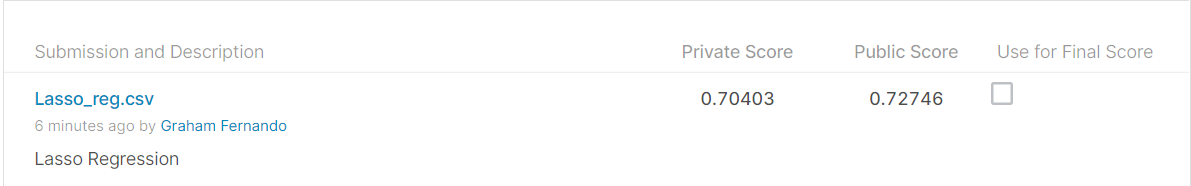

In [ ]:
pd.DataFrame([['LightGBM',0.63838,0.65797],['CatBoost',0.70170,0.73363],['XGBoost',0.72175,0.74070],['Linear_reg_with_rolling_window',3.73342,0.75996],\
              ['Linear_reg_without_rolling_window',0.70399,0.72709],['Elastic_net',0.70314,0.72870],['Ridge_reg',0.70462,0.72694],\
              ['Lasso_reg',0.70403,0.72746]],columns=['Model','Private_Score','Public_Score'])

,Model,Private_Score,Public_Score
0,LightGBM,0.63838,0.65797
1,CatBoost,0.70170,0.73363
2,XGBoost,0.72175,0.74070
3,Linear_reg_with_rolling_window,3.73342,0.75996
4,Linear_reg_without_rolling_window,0.70399,0.72709
5,Elastic_net,0.70314,0.72870
6,Ridge_reg,0.70462,0.72694
7,Lasso_reg,0.70403,0.72746
